## Part 4 - RandomForest Classifier

In this jupyter notebook I will be feeding the data that are coming from Part 2 into a Random Forest classifier, to predict whether a post is coming either from the sustainability or climate change subreddit. More precisely, there will be two different models:i) the first one is using only the words that are coming from the title_selftext column; ii) the second one instead will be adding the sentiment score. The goal is to see if the sentiment detected in the different texts can improve to the accuracy score of the classifier model

### Section 1 - Library and Data Import

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,  cross_val_score,  RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.preprocessing import FunctionTransformer
import pprint as pp

from sklearn.pipeline import FeatureUnion
import sklearn.metrics as metrics



In [34]:
df = pd.read_csv('../data/reddits_cleaned_sentiment.csv')

In [35]:
#checking first 2 rows
df.head(2) 

,subreddit,title_selftext,sentiment_score
0,1,why does many big crop starting to have sustai...,0.0
1,1,use new phone for 5 years or refurbished phone...,0.0


### Section 2 - Random Forest Classifier

There are only two different things that I will be using in both model and that I want to include in this section:i)the null model; ii) a common stop_words hyperparameter

In [36]:
#The Null Model
null_model = df['subreddit'].value_counts(normalize=True)
#Baseline Accuracy
null_model

1    0.500438
0    0.499562
Name: subreddit, dtype: float64

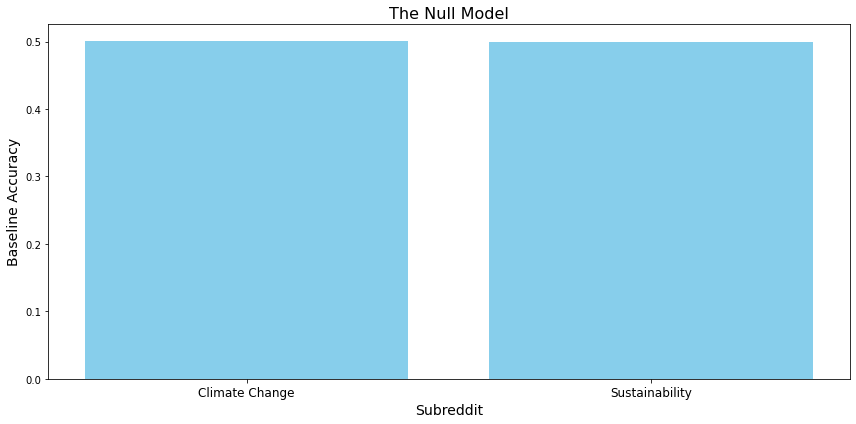

In [37]:
plt.figure(figsize=(12,6))
x = range(len(null_model.reset_index()))
y = null_model.reset_index().loc[:,'subreddit']
plt.bar(x,y, color='skyblue')
ax = plt.subplot()
ax.set_xticks(x)
ax.set_xticklabels(['Climate Change', 'Sustainability'], fontdict= {'fontsize':12})
ax.set_xlabel('Subreddit', fontdict= {'fontsize':14})
ax.set_ylabel('Baseline Accuracy', fontdict= {'fontsize':14})
ax.set_title('The Null Model', fontdict = {'fontsize':16})
plt.tight_layout();
plt.savefig(('../images/null_model.png'))

In [38]:
#Here I am creating a new stop_words vocabulary for both models
cvec = CountVectorizer(stop_words='english')
stop_words = list(cvec.get_stop_words())
lst = ['help','com' ,'have','ve' ,"does", 'know', "don", 'want', 'website', 'row', 'let', 'hey', 'guys', 
       'like', 'hey', 'place', 'http', 'www', 'bytes', 'think', "don't", "doesn't", "does", 'just', 
       'people', 'use',"i've", 'hi', 'need', 'doesn']

stop_words = stop_words + lst

### Section 2.1 - Random Forest without Sentiment Analysis

**Step 1** Assembling Predictors, Target and train_test_split


In [39]:
X = df['title_selftext']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

**Step 2** Instantiate and fitting the Pipeline  

In [40]:
# Instantiate a pipeline
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('forest', RandomForestClassifier())
])

#fitting the pipe
pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()),
                ('forest', RandomForestClassifier())])

In [41]:
#Checking at my train, test, cross val score
pipe.score(X_train,y_train), pipe.score(X_test,y_test), cross_val_score(pipe,X_train,y_train ).mean()

(0.9948324720786798, 0.808, 0.8084669168751738)

**Step 3** Instantiate and Fitting RandomizedSearchCV

In [42]:
#First off, I want to define the parameters for the models established within the pipeline 
params = {
    'vect__stop_words':[stop_words],
    'vect__min_df': list(range(1,10)),
    'vect__max_df': [1.0, .75, .5],
    'vect__binary': [True, False],
    'vect__ngram_range': [(1,1), (1,2)], 
    'vect__max_features': [1_000, 2_000],
    'forest__min_samples_split': [2,3,4],
    'forest__min_samples_leaf':[1,2,3],
    'forest__max_depth':[None, 3,5],
    'forest__max_features':['auto',3,5],
    'forest__ccp_alpha':[0.0,0.1,0.3]
    
}

#Instantiating GridSearch with pipe and parameters established before
#setting up a random state to ensure replicability of results
rs = RandomizedSearchCV(pipe, params, scoring='accuracy', n_iter=10, random_state=430)

#Fitting the GridSearch
rs.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('forest',
                                              RandomForestClassifier())]),
                   param_distributions={'forest__ccp_alpha': [0.0, 0.1, 0.3],
                                        'forest__max_depth': [None, 3, 5],
                                        'forest__max_features': ['auto', 3, 5],
                                        'forest__min_samples_leaf': [1, 2, 3],
                                        'forest__min_samples_split': [2, 3, 4],
                                        'vect__binary': [True, False],
                                        'vect__max_df': [1.0...
                                        'vect__min_df': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9],
                                        'vect__ngram_range': [(1, 1), (1, 2)],
                                        'vect__

In [43]:
#Taking a look at cross val score
rs.best_score_

0.8148051153739226

In [44]:
#Taking a look at best parameters
rs.best_params_

{'vect__stop_words': ['within',
  'is',
  'seeming',
  'very',
  'empty',
  'afterwards',
  'noone',
  'such',
  'nobody',
  'without',
  'about',
  'becomes',
  'fire',
  'here',
  'whoever',
  'beforehand',
  'on',
  'eight',
  'hereby',
  'becoming',
  'per',
  'show',
  'whose',
  'least',
  'one',
  'every',
  'beside',
  'who',
  'twenty',
  'find',
  'also',
  'ltd',
  'alone',
  'therein',
  'twelve',
  'as',
  'however',
  'other',
  'seem',
  'namely',
  'since',
  'she',
  'though',
  'found',
  'three',
  'next',
  'before',
  'do',
  'give',
  'wherever',
  'thereby',
  'fifty',
  'hundred',
  'seems',
  'thin',
  'sincere',
  'describe',
  'many',
  'system',
  'two',
  'now',
  'were',
  'me',
  'can',
  'few',
  'formerly',
  'ten',
  'this',
  'its',
  'seemed',
  'any',
  'no',
  'eg',
  'amount',
  'which',
  'neither',
  'upon',
  'into',
  'has',
  'mill',
  'thereafter',
  'first',
  'both',
  'some',
  'towards',
  'front',
  'same',
  'cannot',
  'wherein',
  'a

**Step 4** Model Evaluation

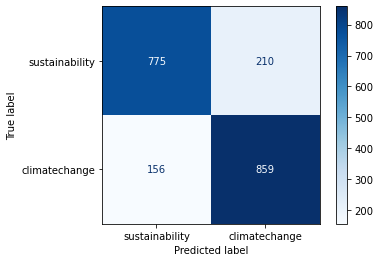

In [45]:
# I want to first take a look at my confusion matrix
plot_confusion_matrix(rs, X_test, y_test, display_labels=['sustainability', 'climatechange'], 
                      cmap='Blues')

In [46]:
# Source: this graph is coming from class classification metrics II
#looking at the predictions
preds = rs.predict(X_test)

#identifying values of my confusion matrix 
tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()

# calculating sensitivity, specificity and overall accuracy
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
accuracy = (tp+tn)/(tp+tn+fn+fp)
precision = (tp)/(tp+fp)
#printing results
sensitivity, specificity, accuracy, precision

(0.8463054187192118, 0.7868020304568528, 0.817, 0.80355472404116)

In [47]:
#calculating ROC AUC Score
probs = rs.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, probs)

0.8988937510939962

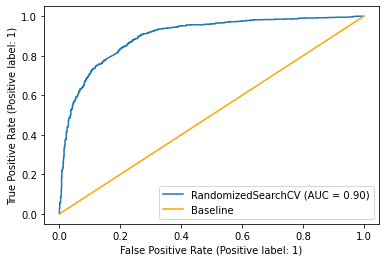

In [48]:
# Source: this graph is coming from class classification metrics II
# I want to visualize the false positive rate against the true positive rate
metrics.plot_roc_curve(rs, X_test, y_test)
plt.plot([0,1], [0,1], color ='orange', label ='Baseline')
plt.legend()

/Users/filoradice/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


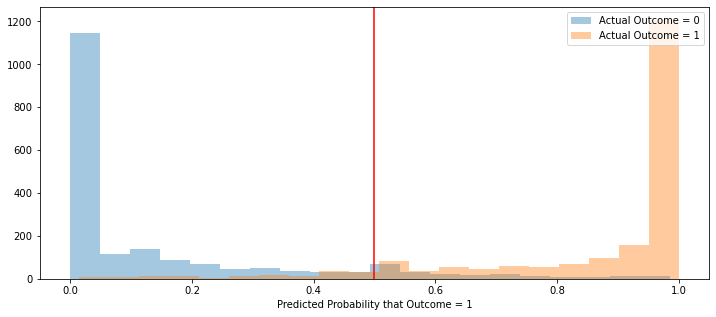

In [49]:
# Source: this graph is coming from class classification metrics II
df_probs = pd.DataFrame({'true_values': y_test, 'preds_prob':probs})
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in df_probs.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')
# Add cutoff line
plt.axvline(.5, color='r')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

### Section 2.2 - Random Forest with Sentiment Analysis

**Step 1** Assembling Predictors, Target and train_test_split

In [50]:
X = df.drop(columns=['subreddit'])
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)


**Step 2** Transforming predictors; instantiating two  separate Pipelines 

In [51]:
# all functions below and everything related to feature union comes from Professor Riley Dallas

In [52]:
def get_title(df):
    return df['title_selftext']

get_title_transformer = FunctionTransformer(get_title, validate=False)

In [53]:
def get_other_col(df):
    return df[['sentiment_score']]
get_col_transformer = FunctionTransformer(get_other_col, validate=False)

In [54]:
pipe_cv = Pipeline([
    ('title_transform', get_title_transformer),
    ('vect', CountVectorizer())
])


In [55]:
pipe_model = Pipeline([
    ('feats', FeatureUnion([
        ('vect_pipe', pipe_cv),
        ('other_cols', get_col_transformer)
    ])),
    ('forest', RandomForestClassifier())
])

**Step 3** Instantiate and Fitting RandomizedSearchCV

In [56]:
#checking at how should I call pipes's parameters
pp.pprint(sorted(pipe_model.get_params().keys()))

['feats',
 'feats__n_jobs',
 'feats__other_cols',
 'feats__other_cols__accept_sparse',
 'feats__other_cols__check_inverse',
 'feats__other_cols__func',
 'feats__other_cols__inv_kw_args',
 'feats__other_cols__inverse_func',
 'feats__other_cols__kw_args',
 'feats__other_cols__validate',
 'feats__transformer_list',
 'feats__transformer_weights',
 'feats__vect_pipe',
 'feats__vect_pipe__memory',
 'feats__vect_pipe__steps',
 'feats__vect_pipe__title_transform',
 'feats__vect_pipe__title_transform__accept_sparse',
 'feats__vect_pipe__title_transform__check_inverse',
 'feats__vect_pipe__title_transform__func',
 'feats__vect_pipe__title_transform__inv_kw_args',
 'feats__vect_pipe__title_transform__inverse_func',
 'feats__vect_pipe__title_transform__kw_args',
 'feats__vect_pipe__title_transform__validate',
 'feats__vect_pipe__vect',
 'feats__vect_pipe__vect__analyzer',
 'feats__vect_pipe__vect__binary',
 'feats__vect_pipe__vect__decode_error',
 'feats__vect_pipe__vect__dtype',
 'feats__vect_pip

In [57]:
params_2 = {
    'feats__vect_pipe__vect__stop_words':[stop_words],
    'feats__vect_pipe__vect__min_df': list(range(1,10)),
    'feats__vect_pipe__vect__max_df': [1.0, .75, .5],
    'feats__vect_pipe__vect__binary': [True, False],
    'feats__vect_pipe__vect__ngram_range': [(1,1), (1,2)], 
    'feats__vect_pipe__vect__max_features': [1_000, 2_000], 
    'forest__min_samples_split': [2,3,4],
    'forest__min_samples_leaf':[1,2,3],
    'forest__max_depth':[None, 3,5],
    'forest__max_features':['auto',3,5],
    'forest__ccp_alpha':[0.0,0.1,0.3]
}

rs_2 = RandomizedSearchCV(pipe_model, params_2, scoring='accuracy', random_state=430)
rs_2.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('feats',
                                              FeatureUnion(transformer_list=[('vect_pipe',
                                                                              Pipeline(steps=[('title_transform',
                                                                                               FunctionTransformer(func=<function get_title at 0x7fef86164af0>)),
                                                                                              ('vect',
                                                                                               CountVectorizer())])),
                                                                             ('other_cols',
                                                                              FunctionTransformer(func=<function get_other_col at 0x7fef86164ca0>))])),
                                             ('forest',
                                              RandomFores

In [58]:
#looking at best accuracy score and best parameters
print(rs_2.best_score_) 
print(rs_2.best_params_)

0.8146371976647206
{'forest__min_samples_split': 3, 'forest__min_samples_leaf': 3, 'forest__max_features': 5, 'forest__max_depth': None, 'forest__ccp_alpha': 0.0, 'feats__vect_pipe__vect__stop_words': ['within', 'is', 'seeming', 'very', 'empty', 'afterwards', 'noone', 'such', 'nobody', 'without', 'about', 'becomes', 'fire', 'here', 'whoever', 'beforehand', 'on', 'eight', 'hereby', 'becoming', 'per', 'show', 'whose', 'least', 'one', 'every', 'beside', 'who', 'twenty', 'find', 'also', 'ltd', 'alone', 'therein', 'twelve', 'as', 'however', 'other', 'seem', 'namely', 'since', 'she', 'though', 'found', 'three', 'next', 'before', 'do', 'give', 'wherever', 'thereby', 'fifty', 'hundred', 'seems', 'thin', 'sincere', 'describe', 'many', 'system', 'two', 'now', 'were', 'me', 'can', 'few', 'formerly', 'ten', 'this', 'its', 'seemed', 'any', 'no', 'eg', 'amount', 'which', 'neither', 'upon', 'into', 'has', 'mill', 'thereafter', 'first', 'both', 'some', 'towards', 'front', 'same', 'cannot', 'wherein', 

**Step 4** Model Evaluation

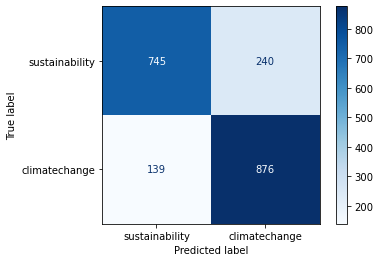

In [59]:
# I want to first take a look at my confusion matrix
plot_confusion_matrix(rs_2, X_test, y_test, display_labels=['sustainability', 'climatechange'], 
                      cmap='Blues')

In [60]:
#looking at the predictions
preds = rs_2.predict(X_test)

#identifying values of my confusion matrix 
tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()

# calculating sensitivity, specificity and overall accuracy
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
accuracy = (tp+tn)/(tp+tn+fn+fp)
precision = (tp)/(tp+fp)
#printing results
sensitivity, specificity, accuracy, precision

(0.8630541871921182, 0.7563451776649747, 0.8105, 0.7849462365591398)

In [61]:
#calculating ROC AUC Score
probs = rs_2.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, probs)

0.9003860868695457

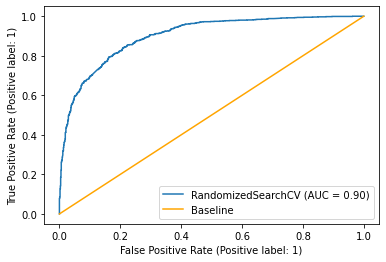

In [62]:
# Source: this graph is coming from class classsification metrics II
# I want to visualize teh false positive rate against the true positive rate
metrics.plot_roc_curve(rs_2, X_test, y_test)
plt.plot([0,1], [0,1], color ='orange', label ='Baseline')
plt.legend()

/Users/filoradice/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


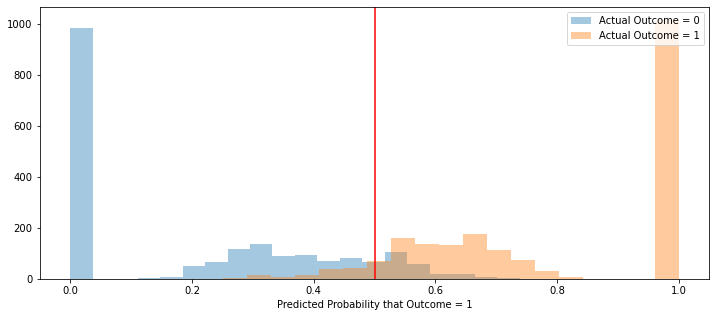

In [63]:
# Source: this graph is coming from class classification metrics II

df_probs = pd.DataFrame({'true_values': y_test, 'preds_prob':probs})
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in df_probs.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')
# Add cutoff line
plt.axvline(.5, color='r')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

### Section 3 - Conclusion

By looking at all different metrics, we can conclude that the sentiment analysis does not add value to the prediction of my Random Forest model classifier. Meaning that, the difference in the sentiment score across the different subreddits does not improve model predictions. In fact, the best accuracy score for the model with sentiment analysis is .816 against .821 for the one without. 
Below, the summary of the different other scores computed before

Random Forest Scores **without** Sentiment Analysis: 
1. sensitivity 0.847 
2. specificity 0.785
3. accuracy 0.816
4. precision 0.802

Random Forest Scores **with** Sentiment Analysis:  
1. sensitivity 0.870 
2. specificity 0.751
3. accuracy 0.811 
4. precision 0.783
